In [1]:
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from ast import literal_eval
from model.loss import Pairwise_ranking_loss
from model.drmm import Gen_DRMM_Model
from model.pacrr import Gen_PACRR_Model
from model.pacrr_drmm import Gen_PACRR_DRMM_Model
from model.callback import LossHistory, _metric

from utility.utility import ndcg, mAP_score, highlight, history_plot
from IPython.core.display import display, HTML

pd.options.mode.chained_assignment = None

display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 99)
pd.set_option('display.max_rows', 50)

%matplotlib inline

In [2]:
df = pd.read_csv('./data/paccr_drmm_all.csv', converters={"positive_hist"      : literal_eval,
                                                          "negative_hist"      : literal_eval,
                                                          "query_idf"          : literal_eval,
                                                          "negative_sim_matrix": literal_eval,
                                                          "positive_sim_matrix": literal_eval,
                                                          "idf_softmax"        : literal_eval})

df = df[['query_preprocessed', 'positive_hist', 'negative_hist', 'query_idf', 'negative_sim_matrix', 'positive_sim_matrix', 'idf_softmax']]

In [3]:
test = pd.read_csv('./data/paccr_drmm_all_test.csv', converters={"hist"       : literal_eval,
                                                                 "query_idf"  : literal_eval,
                                                                 "sim_matrix" : literal_eval,
                                                                 "idf_softmax": literal_eval})
test['binary_relevance'] = test['median_relevance'].apply(lambda x: 0 if x <= 2 else 1)

In [4]:
# dev_q = set(random.sample(list(df['query_preprocessed'].unique()), 40))

with open('./data/dev_q.pkl', 'rb') as f:
    dev_q = pickle.load(f)
    
dev_q = set(test[test['query'].isin(dev_q)]['query_preprocessed'].unique())
train_q = set(df['query_preprocessed'].unique()) - dev_q

In [5]:
train = df[df['query_preprocessed'].isin(train_q)]
dev = df[df['query_preprocessed'].isin(dev_q)]
test = test[test['query_preprocessed'].isin(dev_q)]

In [6]:
metadata = {'negative_sim_matrix': tf.constant(train['negative_sim_matrix'].tolist(), dtype=tf.float32), 
            'positive_sim_matrix': tf.constant(train['positive_sim_matrix'].tolist(), dtype=tf.float32),
            'idf_softmax'        : tf.constant(train['idf_softmax'].tolist(), dtype=tf.float32),
            'query_idf'          : tf.ragged.constant(train['query_idf'], dtype=tf.float32, ragged_rank=1),
            'positive_hist'      : tf.ragged.constant(train['positive_hist'], dtype=tf.float32, ragged_rank=1),
            'negative_hist'      : tf.ragged.constant(train['negative_hist'], dtype=tf.float32, ragged_rank=1)}

In [7]:
metadata_dev = {'negative_sim_matrix': tf.constant(dev['negative_sim_matrix'].tolist(), dtype=tf.float32),
                'positive_sim_matrix': tf.constant(dev['positive_sim_matrix'].tolist(), dtype=tf.float32),
                'idf_softmax'        : tf.constant(dev['idf_softmax'].tolist(), dtype=tf.float32),
                'query_idf'          : tf.ragged.constant(dev['query_idf'], dtype=tf.float32, ragged_rank=1),
                'positive_hist'      : tf.ragged.constant(dev['positive_hist'], dtype=tf.float32, ragged_rank=1),
                'negative_hist'      : tf.ragged.constant(dev['negative_hist'], dtype=tf.float32, ragged_rank=1)}

In [8]:
firstk = 8
lq = 6
lg = 5
nf = 32
ns = 2

In [9]:
drmm = Gen_DRMM_Model()
drmm.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=.1), loss=Pairwise_ranking_loss)

history_drmm = LossHistory(metadata_dev)
drmm_metric = _metric(test)

total_epoch_count = 100
batch_size = 128

drmm.fit(x=metadata, y=tf.constant([0.]*len(train)),
         validation_data=(metadata_dev, tf.constant([0.]*len(dev))),
         shuffle=True,
         epochs=total_epoch_count,
         batch_size=batch_size,
         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                    history_drmm, drmm_metric])

Epoch 1/100


C:\Users\kwon\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


647/647 [==============================] - 26s 41ms/step - loss: 0.9992 - val_loss: 0.9990
Epoch 2/100
647/647 [==============================] - 11s 18ms/step - loss: 0.9987 - val_loss: 0.9987
Epoch 3/100
647/647 [==============================] - 13s 19ms/step - loss: 0.9984 - val_loss: 0.9984
Epoch 4/100
647/647 [==============================] - 13s 20ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 5/100
647/647 [==============================] - 11s 16ms/step - loss: 0.9980 - val_loss: 0.9981
Epoch 6/100
647/647 [==============================] - 9s 14ms/step - loss: 0.9979 - val_loss: 0.9979
Epoch 7/100
647/647 [==============================] - 8s 12ms/step - loss: 0.9977 - val_loss: 0.9979
Epoch 8/100
647/647 [==============================] - 9s 13ms/step - loss: 0.9977 - val_loss: 0.9978
Epoch 9/100
647/647 [==============================] - 9s 14ms/step - loss: 0.9976 - val_loss: 0.9977
Epoch 10/100
647/647 [==============================] - 12s 18ms/step - loss: 0.9975 - va

Epoch 41/100
647/647 [==============================] - 8s 13ms/step - loss: 0.9971 - val_loss: 0.9975
Epoch 42/100
647/647 [==============================] - 8s 13ms/step - loss: 0.9971 - val_loss: 0.9975
Epoch 43/100
647/647 [==============================] - 10s 15ms/step - loss: 0.9971 - val_loss: 0.9975
Epoch 44/100
647/647 [==============================] - 9s 14ms/step - loss: 0.9971 - val_loss: 0.9975
Epoch 45/100
647/647 [==============================] - 8s 13ms/step - loss: 0.9971 - val_loss: 0.9975
Epoch 46/100
647/647 [==============================] - 8s 12ms/step - loss: 0.9971 - val_loss: 0.9975
Epoch 47/100
647/647 [==============================] - 9s 13ms/step - loss: 0.9971 - val_loss: 0.9974
Epoch 48/100
647/647 [==============================] - 8s 12ms/step - loss: 0.9971 - val_loss: 0.9974
Epoch 49/100
647/647 [==============================] - 11s 17ms/step - loss: 0.9971 - val_loss: 0.9974
Epoch 50/100
647/647 [==============================] - 9s 14ms/step - 

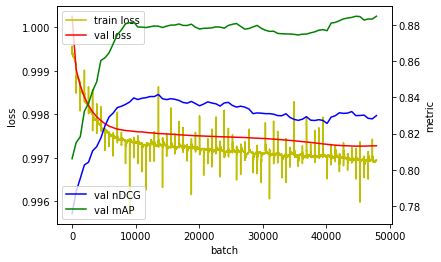

In [11]:
history_plot(history_drmm, drmm_metric, batch_size, df=train)

In [12]:
pacrr = Gen_PACRR_Model(firstk, lq, lg, nf, ns)
pacrr.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=.1), loss=Pairwise_ranking_loss)

history_pacrr = LossHistory(metadata_dev)
pacrr_metric = _metric(test)
total_epoch_count = 100
batch_size = 1024

pacrr.fit(x=metadata, y=tf.constant([0.]*len(train)), 
          validation_data=(metadata_dev, tf.constant([0.]*len(dev))),
          shuffle=True,
          epochs=total_epoch_count,
          batch_size=batch_size,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                     history_pacrr, pacrr_metric])

Epoch 1/100
81/81 [==============================] - 82s 1s/step - loss: 1.0004 - val_loss: 0.9991
Epoch 2/100
81/81 [==============================] - 74s 915ms/step - loss: 0.9972 - val_loss: 0.9933
Epoch 3/100
81/81 [==============================] - 73s 899ms/step - loss: 0.9808 - val_loss: 0.9556
Epoch 4/100
81/81 [==============================] - 73s 898ms/step - loss: 0.8745 - val_loss: 0.8341
Epoch 5/100
81/81 [==============================] - 74s 911ms/step - loss: 0.7992 - val_loss: 0.7995
Epoch 6/100
81/81 [==============================] - 72s 886ms/step - loss: 0.7738 - val_loss: 0.8087
Epoch 7/100
81/81 [==============================] - 71s 878ms/step - loss: 0.7616 - val_loss: 0.8179
Epoch 8/100
81/81 [==============================] - 75s 920ms/step - loss: 0.7501 - val_loss: 0.8217
Epoch 9/100
81/81 [==============================] - 70s 862ms/step - loss: 0.7445 - val_loss: 0.8058
Epoch 10/100
81/81 [==============================] - 76s 941ms/step - loss: 0.7397 -

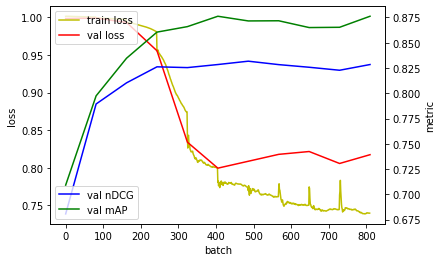

In [14]:
history_plot(history_pacrr, pacrr_metric, batch_size, df=train)

In [15]:
pacrr_drmm = Gen_PACRR_DRMM_Model(firstk, lq, lg, nf, ns)
pacrr_drmm.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=.1), loss=Pairwise_ranking_loss)

history_pacrr_drmm = LossHistory(metadata_dev)
pacrr_drmm_metric = _metric(test)
total_epoch_count = 100
batch_size = 1024

pacrr_drmm.fit(x=metadata, y=tf.constant([0.]*len(train)),
               validation_data=(metadata_dev, tf.constant([0.]*len(dev))),
               shuffle=True,
               epochs=total_epoch_count,
               batch_size=batch_size,
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
                          history_pacrr_drmm, pacrr_drmm_metric])

Epoch 1/100
81/81 [==============================] - 82s 1s/step - loss: 0.8093 - val_loss: 0.8259
Epoch 2/100
81/81 [==============================] - 72s 888ms/step - loss: 0.7664 - val_loss: 0.8046
Epoch 3/100
81/81 [==============================] - 75s 927ms/step - loss: 0.7471 - val_loss: 0.8181
Epoch 4/100
81/81 [==============================] - 69s 855ms/step - loss: 0.7377 - val_loss: 0.8288
Epoch 5/100
81/81 [==============================] - 75s 921ms/step - loss: 0.7204 - val_loss: 0.8145
Epoch 6/100
81/81 [==============================] - 72s 891ms/step - loss: 0.7125 - val_loss: 0.8097
Epoch 7/100
81/81 [==============================] - 71s 882ms/step - loss: 0.7035 - val_loss: 0.8177
Epoch 8/100
81/81 [==============================] - 70s 867ms/step - loss: 0.6953 - val_loss: 0.8236
Epoch 9/100
81/81 [==============================] - 71s 872ms/step - loss: 0.6874 - val_loss: 0.8135


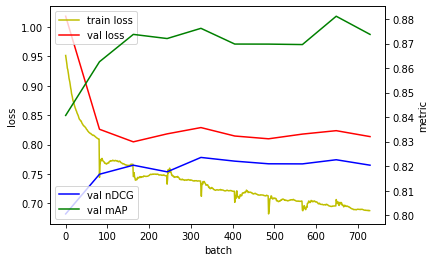

In [17]:
history_plot(history_pacrr_drmm, pacrr_drmm_metric, batch_size, df=train)

In [18]:
drmm_weight = drmm.get_weights()
with open('./model_weights/drmm_weight.pkl', 'wb') as f:
    pickle.dump(drmm_weight, f)

pacrr_weight = pacrr.get_weights()
with open('./model_weights/pacrr_weight.pkl', 'wb') as f:
    pickle.dump(pacrr_weight, f)

pacrr_drmm_weight = pacrr_drmm.get_weights()
with open('./model_weights/pacrr_drmm_weight.pkl', 'wb') as f:
    pickle.dump(pacrr_drmm_weight, f)

In [19]:
# drmm = Gen_DRMM_Model()
# with open('./model_weights/drmm_weight.pkl', 'rb') as f:
#     drmm_weights = pickle.load(f)
# drmm.set_weights(drmm_weights)

# pacrr = Gen_PACRR_Model(firstk, lq, lg, nf, ns)
# with open('./model_weights/pacrr_weight.pkl', 'rb') as f:
#     pacrr_weights = pickle.load(f)
# pacrr.set_weights(pacrr_weights)

# pacrr_drmm = Gen_PACRR_DRMM_Model(firstk, lq, lg, nf, ns)
# with open('./model_weights/pacrr_drmm_weight.pkl', 'rb') as f:
#     pacrr_drmm_weights = pickle.load(f)
# pacrr_drmm.set_weights(pacrr_drmm_weights)

In [20]:
ndcg_test = test[test['query'] == random.sample(dev_q, 1)[0]]
metadata_ndcg = {'negative_sim_matrix' : tf.constant(ndcg_test['sim_matrix'].tolist(), dtype=tf.float32),
                 'positive_sim_matrix' : tf.constant(ndcg_test['sim_matrix'].tolist(), dtype=tf.float32),
                 'idf_softmax'         : tf.constant(ndcg_test['idf_softmax'].tolist(), dtype=tf.float32),
                 'query_idf'           : tf.ragged.constant(ndcg_test['query_idf'], dtype=tf.float32, ragged_rank=1),
                 'positive_hist'       : tf.ragged.constant(ndcg_test['hist'], dtype=tf.float32, ragged_rank=1),
                 'negative_hist'       : tf.ragged.constant(ndcg_test['hist'], dtype=tf.float32, ragged_rank=1)}

ndcg_test.insert(5, 'rel_drmm', drmm.predict(metadata_ndcg)[:len(ndcg_test)], True)
ndcg_test.insert(5, 'rel_pacrr', pacrr.predict(metadata_ndcg)[:len(ndcg_test)], True)
ndcg_test.insert(5, 'rel_pacrr_drmm', pacrr_drmm.predict(metadata_ndcg)[:len(ndcg_test)], True)

pacrr_drmm_pred = ndcg_test.sort_values(by=['rel_pacrr_drmm'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel_pacrr_drmm', 'rel_pacrr', 'rel_drmm']]
print('nDCG : ', ndcg(pacrr_drmm_pred.median_relevance.values-1, form='exp'))
print('mAP : ', mAP_score([1 if i>2 else 0 for i in pacrr_drmm_pred.median_relevance.values]))
pacrr_drmm_pred.style.apply(highlight, axis=1).set_properties(subset=['query', "product_title"], **{'text-align': 'left'}).hide_index()

nDCG :  0.938725563443045
mAP :  0.7999704139772789


query,product_title,median_relevance,rel_pacrr_drmm,rel_pacrr,rel_drmm
nike shoes,Nike Women's 'Zoom Hyperquickness' Synthetic Athletic Shoe (Size 6 ),4,0.525553,0.646474,0.031218
nike shoes,Nike Oceania Nm Womens Sneakers Shoes,4,0.504457,0.612522,0.031203
nike shoes,Nike Mens Lunar Cypress Spikeless Golf Shoes,4,0.503705,0.690100,0.031238
nike shoes,Nike 653483 Hyperdunk 2014 TB Men's Basketball Shoes Size 7 1/2,2,0.460047,0.655124,0.029959
nike shoes,Nike Women's Lunar Duet Classic Golf Shoes,4,0.446708,0.592784,0.031242
nike shoes,Nike Men's 'LunarGlide + 4' Mesh Athletic Shoe (Size 10 ),2,0.424927,0.676746,0.019473
nike shoes,Nike Ladies Lunar Duet Sport Golf Shoes,4,0.424132,0.640943,0.031227
nike shoes,Nike Junior's Range Jr Golf Shoes,4,0.418632,0.388259,0.031179
nike shoes,Nike Son Of Force Mid Basketball Shoes New/Display,4,0.372926,0.242602,0.030066
nike shoes,Nike Golf TW '14 Men's Grey/ Black Golf Shoes,4,0.353959,0.215960,0.029251


In [21]:
pacrr_pred = ndcg_test.sort_values(by=['rel_pacrr'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel_pacrr_drmm', 'rel_pacrr', 'rel_drmm']]
print('nDCG : ', ndcg(pacrr_pred.median_relevance.values-1, form='exp'))
print('mAP : ', mAP_score([1 if i>2 else 0 for i in pacrr_pred.median_relevance.values]))
pacrr_pred.style.apply(highlight, axis=1).set_properties(subset=['query', "product_title"], **{'text-align': 'left'}).hide_index()

nDCG :  0.8930952271102951
mAP :  0.7343098387345535


query,product_title,median_relevance,rel_pacrr_drmm,rel_pacrr,rel_drmm
nike shoes,Nike Mens Lunar Cypress Spikeless Golf Shoes,4,0.503705,0.690100,0.031238
nike shoes,Nike Men's 'LunarGlide + 4' Mesh Athletic Shoe (Size 10 ),2,0.424927,0.676746,0.019473
nike shoes,Nike 653483 Hyperdunk 2014 TB Men's Basketball Shoes Size 7 1/2,2,0.460047,0.655124,0.029959
nike shoes,Nike Women's 'Zoom Hyperquickness' Synthetic Athletic Shoe (Size 6 ),4,0.525553,0.646474,0.031218
nike shoes,Nike Ladies Lunar Duet Sport Golf Shoes,4,0.424132,0.640943,0.031227
nike shoes,Nike Oceania Nm Womens Sneakers Shoes,4,0.504457,0.612522,0.031203
nike shoes,Nike Women's Lunar Duet Classic Golf Shoes,4,0.446708,0.592784,0.031242
nike shoes,"Dr. Scholl's - Men's Michael Air-Pillo Gel Velcro Shoes, Wide Width",2,0.241667,0.560261,0.031236
nike shoes,Nike Mens Lunar Mont Royal Spikeless Golf Shoes,4,0.241667,0.560261,0.031236
nike shoes,Nike Men's 'Jordan SC-3' Leather Athletic Shoe,4,0.201615,0.497974,0.029379


In [22]:
drmm_pred = ndcg_test.sort_values(by=['rel_drmm'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel_pacrr_drmm', 'rel_pacrr', 'rel_drmm']]
print('nDCG : ', ndcg(drmm_pred.median_relevance.values-1, form='exp'))
print('mAP : ', mAP_score([1 if i>2 else 0 for i in drmm_pred.median_relevance.values]))
drmm_pred.style.apply(highlight, axis=1).set_properties(subset=['query', "product_title"], **{'text-align': 'left'}).hide_index()

nDCG :  0.9452389477594161
mAP :  0.8332745259401279


query,product_title,median_relevance,rel_pacrr_drmm,rel_pacrr,rel_drmm
nike shoes,Nike Women's Lunar Duet Classic Golf Shoes,4,0.446708,0.592784,0.031242
nike shoes,Nike Mens Lunar Cypress Spikeless Golf Shoes,4,0.503705,0.690100,0.031238
nike shoes,"Dr. Scholl's - Men's Michael Air-Pillo Gel Velcro Shoes, Wide Width",2,0.241667,0.560261,0.031236
nike shoes,Nike Mens Lunar Mont Royal Spikeless Golf Shoes,4,0.241667,0.560261,0.031236
nike shoes,Nike Ladies Lunar Duet Sport Golf Shoes,4,0.424132,0.640943,0.031227
nike shoes,Nike Women's 'Zoom Hyperquickness' Synthetic Athletic Shoe (Size 6 ),4,0.525553,0.646474,0.031218
nike shoes,Nike Oceania Nm Womens Sneakers Shoes,4,0.504457,0.612522,0.031203
nike shoes,Nike Free 5.0 Womens Training Shoes - BlueDark GreyLime,4,-0.013712,0.266815,0.031194
nike shoes,NIKE Men's Lunar Swingtip Suede Anthracite/Brickhouse Golf Shoes,3,-0.013712,0.266815,0.031194
nike shoes,Nike Womens Lunar Duet Sport Blue/ White/ Thistle Golf Shoes,4,-0.220431,-0.000967,0.031180
